In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [72]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.utils import *

plt.style.use('ggplot')

## 1 Dimensional

In [73]:
d = 1

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.array([[1.0]]),     
    dim=d,
    end_time=1.0,
    num_steps=50
)

(32, 51, 1)
(32, 50, 1)


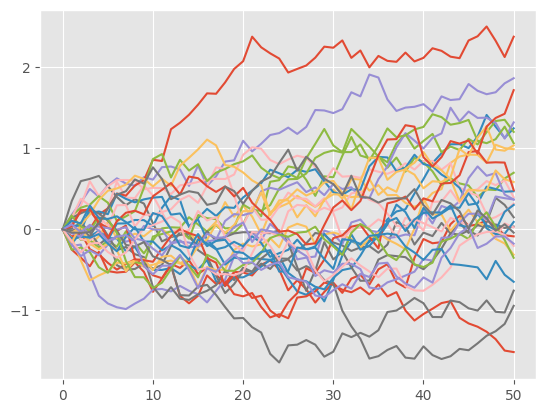

In [75]:
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)))
print(forward_brownian_motion["trajectories"].shape)
print(forward_brownian_motion["scaled_brownians"].shape)
for i in range(32):
    plt.plot(forward_brownian_motion["trajectories"][i, :, 0])

In [76]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = model.learn_p_score(initial_condition=jnp.array([0.0]), 
                                    setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

In [78]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = model.learn_p_star_score(initial_condition=jnp.array([0.0]),
                                              terminal_condition=jnp.array([2.0]),
                                              score_p_state=score_p_state,
                                              setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

(32, 51, 1)
(32, 50, 1)


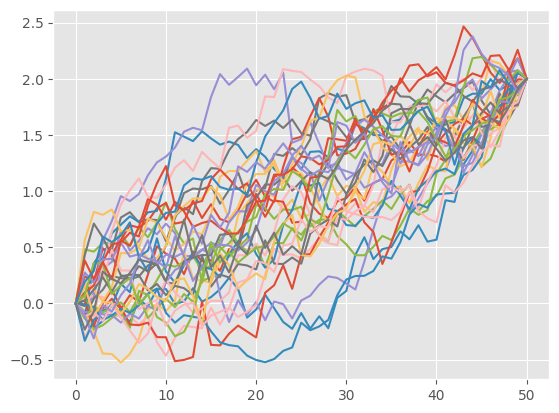

In [77]:
backward_brownian_bridge = model.simulate_backward_bridge(score_p_state=score_p_state, 
                                                          initial_condition=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                          terminal_condition=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)))
print(backward_brownian_bridge["trajectories"].shape)
for i in range(32):
    plt.plot(backward_brownian_bridge["trajectories"][i, :, 0])

(32, 51, 1)


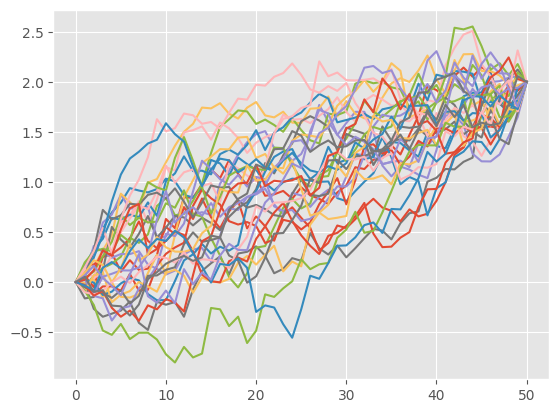

In [79]:
forward_brownian_bridge = model.simulate_forward_bridge(score_p_state=score_p_state, 
                                                        score_p_star_state=score_p_star_state,
                                                        initial_condition=jnp.tile(jnp.array([[0.0]]), reps=(32, 1)), 
                                                        terminal_condition=jnp.tile(jnp.array([[2.0]]), reps=(32, 1)))
print(forward_brownian_bridge["trajectories"].shape)
for i in range(32):
    plt.plot(forward_brownian_bridge["trajectories"][i, :, 0])

## 2 Dimensional

### Learn the transition density of $X_t$

In [81]:
d = 2

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.array([[1.0, 0.0], [0.0, 1.0]]),     
    dim=d,
    end_time=1.0,
    num_steps=50
)

(32, 51, 2)


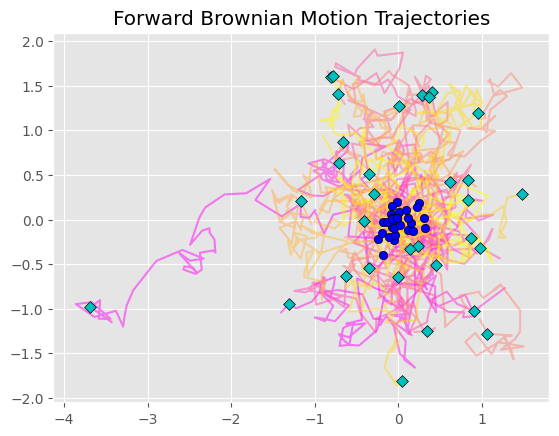

In [83]:
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)))
print(forward_brownian_motion["trajectories"].shape)
plot_2d_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [84]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = model.learn_p_score(initial_condition=jnp.array([0.0, 0.0]), 
                                    setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

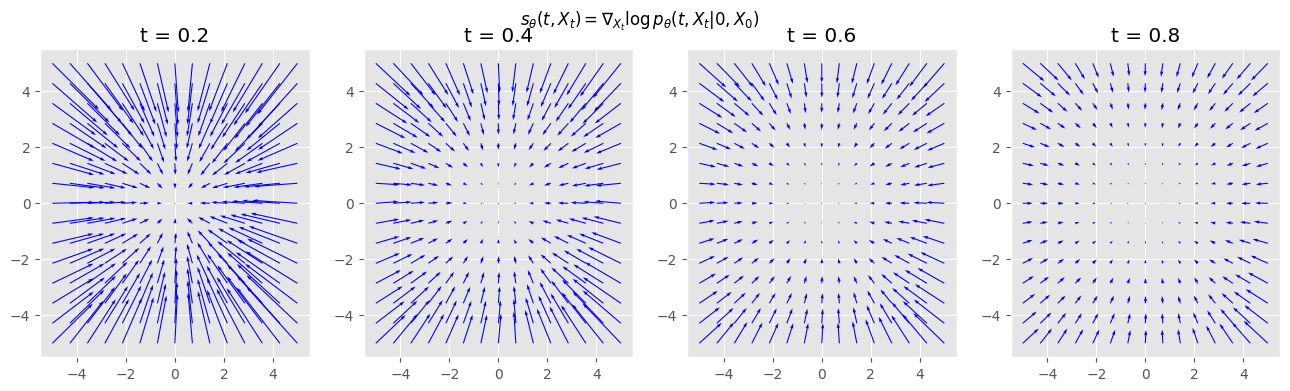

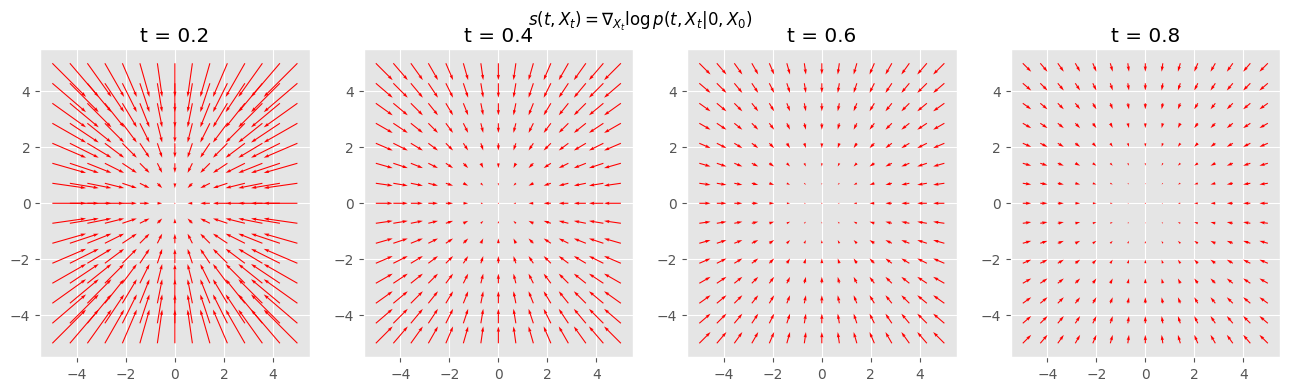

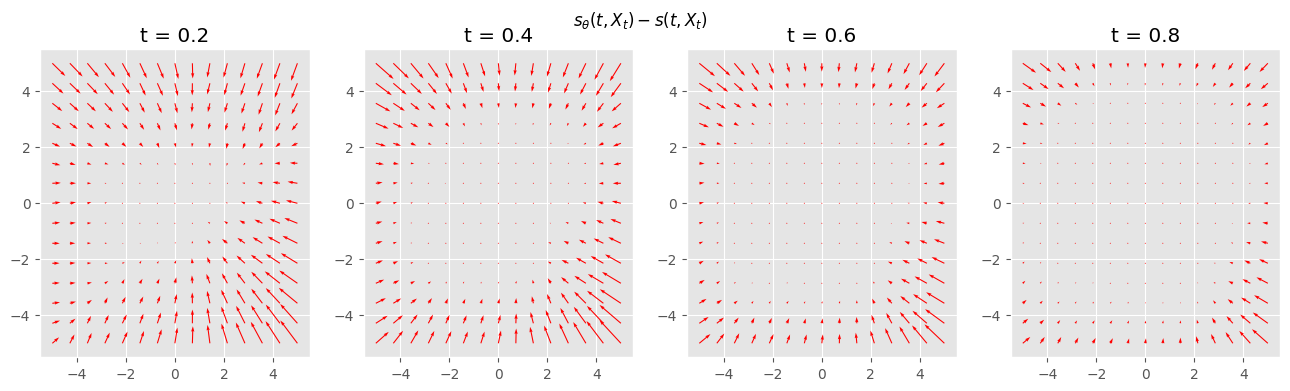

In [87]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t)=\nabla_{X_t}\log p_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: -(x-x0)/t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s(t, X_t)=\nabla_{X_t}\log p(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0: eval_score(score_p_state, x, t) - (-(x-x0)/t),
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s_{\theta}(t, X_t) - s(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]))

### Use learned transition score to simulate the backward bridge

(32, 51, 2)


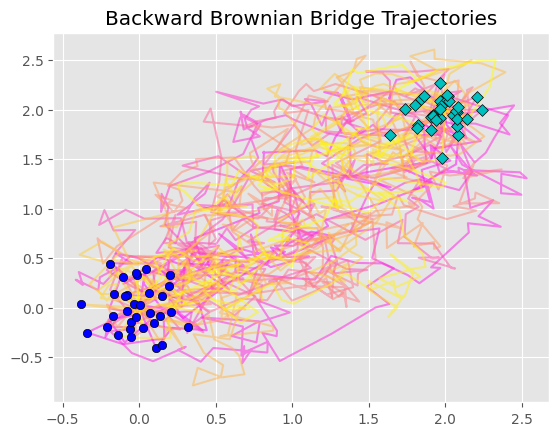

In [90]:
backward_brownian_bridge = model.simulate_backward_bridge(score_p_state=score_p_state, 
                                                          initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                          terminal_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)))
print(backward_brownian_bridge["trajectories"].shape)
plot_2d_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Exam the intermediate stage distribution

For a Brownian bridge $(X^*_t)$, $p^*(t, X^*_t)$ is the transition density, which can be written as:
$$ p^*(t, x_t) = \frac{p(t, x_t|0, x_0)p(T, x_T|t, x_t)}{p(T, x_T|0, x_0)} $$
Take the score for the both sides w.r.t $x_t$:
$$ \nabla_{x_t}\log p^*(t, x_t) = \nabla_{x_t}\log p(t, x_t|0, x_0) + \nabla_{x_t} \log p(T, x_T|t, x_t) - \nabla_{x_t} \log p(T, x_T|0, x_0) $$
Considering all the $p$s have Gaussian closed forms:
$$ p(t, x_t|0, x_0) = C_1\exp(-\frac{\|x_t-x_0\|^2}{2t}) $$
$$ p(T, x_T|t, x_t) = C_2\exp(-\frac{\|x_T-x_t\|^2}{2(T-t)}) $$
$$ p(T, x_T|0, x_0) = C_3\exp(-\frac{\|x_T-x_0\|^2}{2T}) $$
The score of the transition density of the Brownian bridge is:
$$ s^*(t, x_t) = \nabla_{x_t} \log p^*(t, x_t) = \frac{x_T-x_t}{T-t} - \frac{x_t-x_0}{t} $$

In [91]:
# Covariance calculations
def product_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) * N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 + sigma2**2)
    return sigma

def quotient_gaussian(sigma1, sigma2):
    """ Covariance of N(mu1, sigma1^2) / N(mu2, sigma2^2)
    """
    sigma = (sigma1**2 * sigma2**2) / (sigma1**2 - sigma2**2)
    return sigma

def forward_browian_bridge_transition(t, T):
    sigma1 = t
    sigma2 = T - t
    sigma3 = T
    sigma0 = product_gaussian(sigma1, sigma2)
    sigma = quotient_gaussian(sigma0, sigma3)
    return sigma

In [93]:
num_trajectories = 4096
X0 = jnp.tile(jnp.array([[0.0, 0.0]]), reps=(num_trajectories, 1))
XT = jnp.tile(jnp.array([[2.0, 2.0]]), reps=(num_trajectories, 1))
backward_brownian_bridge = model.simulate_backward_bridge(score_p_state=score_p_state, 
                                                          initial_condition=X0, 
                                                          terminal_condition=XT)
print(backward_brownian_bridge["trajectories"].shape)

(4096, 51, 2)


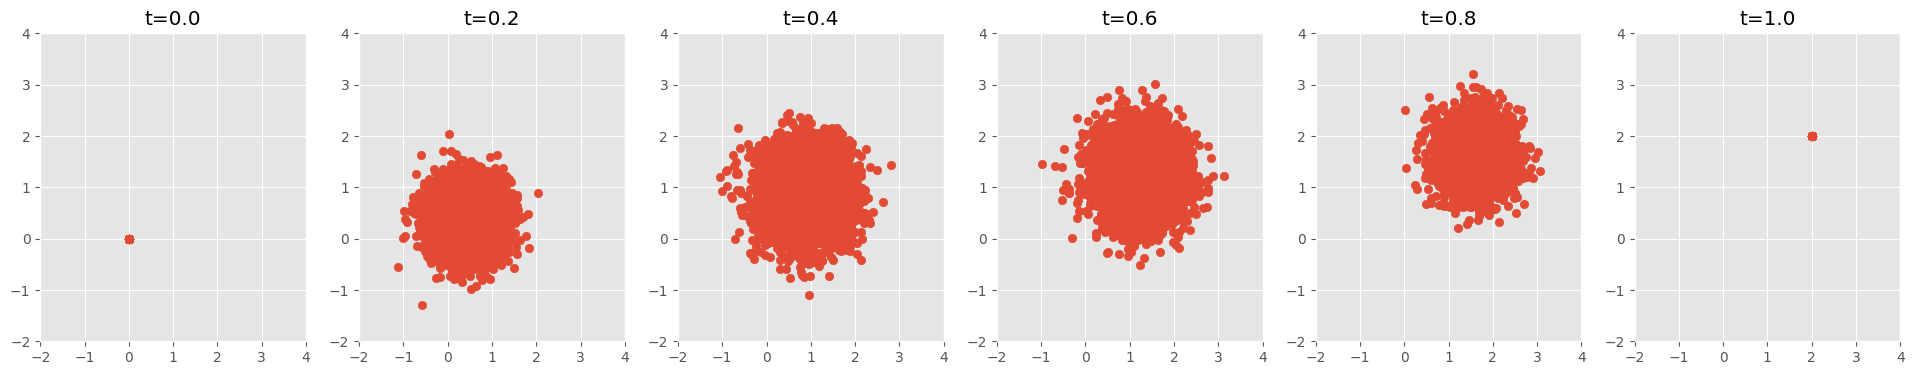

In [94]:
fig, ax = plt.subplots(1, 6, figsize=(24, 4))
for i in range(5+1):
    ax[i].scatter(backward_brownian_bridge["trajectories"][:, i*10, 0], backward_brownian_bridge["trajectories"][:, i*10, 1])
    ax[i].set_title(f"t={model.ts[i*10]:.1f}")
    ax[i].set_xlim([-2.0, 4.0])
    ax[i].set_ylim([-2.0, 4.0])

Text(0, 0.5, 'MSE')

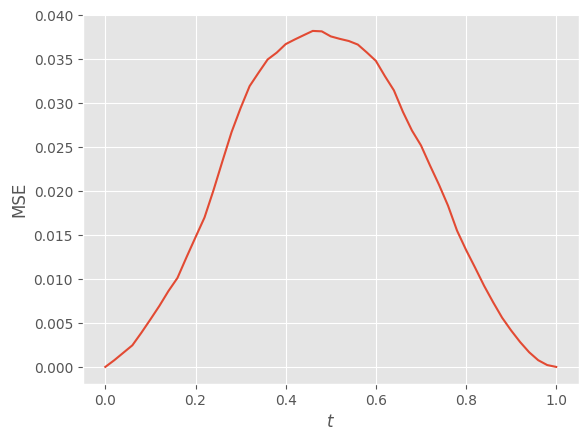

In [95]:
true_variances = jax.vmap(forward_browian_bridge_transition, in_axes=(0, None))(model.ts, model.T)
backward_brownian_bridge_covariance = jax.vmap(lambda x: jnp.cov(x, rowvar=False), in_axes=1)(backward_brownian_bridge["trajectories"])
errors = jax.vmap(lambda x, var: jnp.mean(jnp.square(x - jnp.eye(2)*var)), in_axes=(0, 0))(backward_brownian_bridge_covariance, true_variances)
plt.plot(model.ts, errors)
plt.xlabel(r"$t$")
plt.ylabel("MSE")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [97]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 64,
                "embedding_dim": 64,
                "act": 'leaky_relu',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [64, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = model.learn_p_star_score(initial_condition=jnp.array([0.0, 0.0]),
                                              terminal_condition=jnp.array([1.0, 1.0]),
                                              score_p_state=score_p_state,
                                              setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

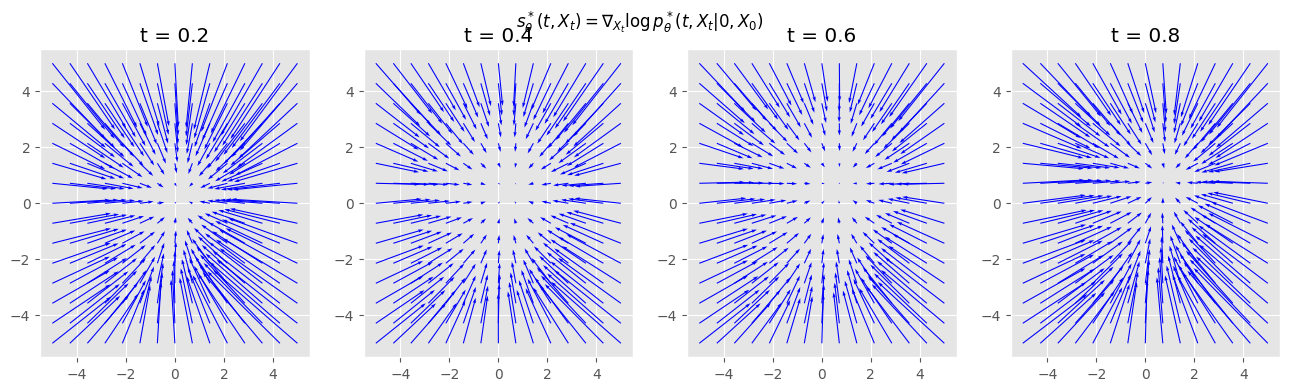

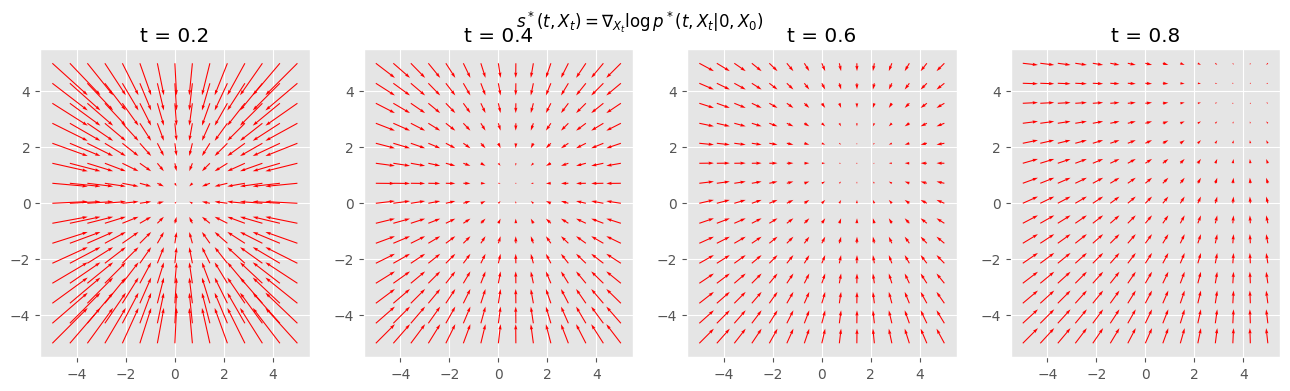

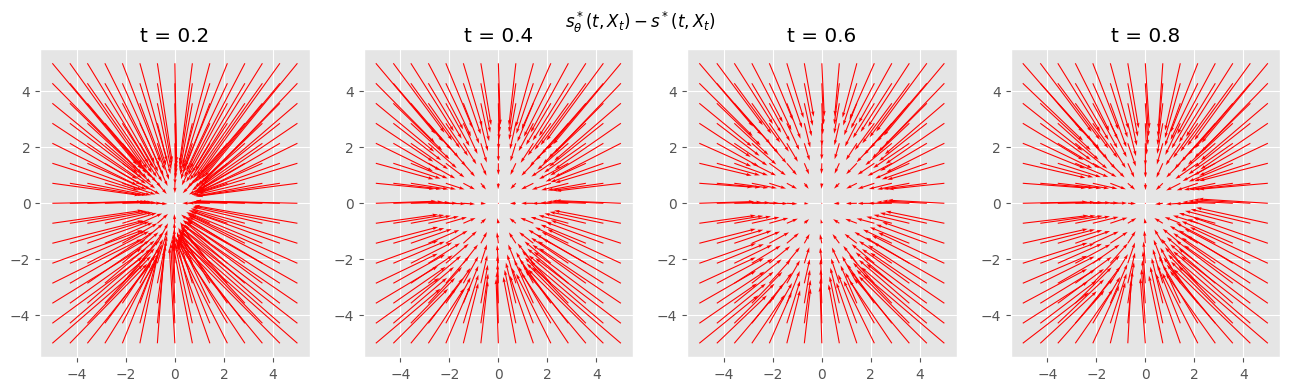

In [101]:
plot_2d_vector_field(X=lambda x, t: eval_score(score_p_star_state, x, t),
                     X_ref=None,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t)=\nabla_{X_t}\log p^*_{\theta}(t, X_t|0, X_0)$",
                     scale=200)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*(t, X_t)=\nabla_{X_t}\log p^*(t,X_t|0,X_0)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([1.0, 1.0]),
                     T=1.0)

plot_2d_vector_field(X=None,
                     X_ref=lambda x, t, x0, xT, T: eval_score(score_p_star_state, x, t) - (xT-x0) / (T-t) - (x-x0) / t,
                     xs=jnp.linspace(-5.0, 5.0, 15),
                     ts=jnp.linspace(0.2, 0.8, 3+1),
                     suptitle=r"$s^*_{\theta}(t, X_t) - s^*(t, X_t)$",
                     scale=200,
                     x0=jnp.array([0.0, 0.0]),
                     xT=jnp.array([1.0, 1.0]),
                     T=1.0)

(32, 51, 2)


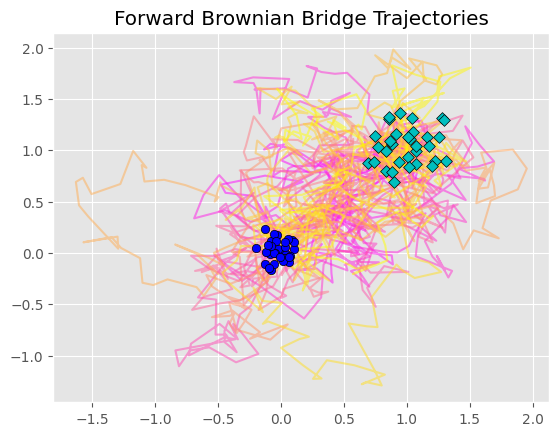

In [102]:
forward_brownian_bridge = model.simulate_forward_bridge(score_p_state=score_p_state, 
                                                        score_p_star_state=score_p_star_state,
                                                        initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                        terminal_condition=jnp.tile(jnp.array([[1.0, 1.0]]), reps=(32, 1)))
print(forward_brownian_bridge["trajectories"].shape)
plot_2d_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

### Higher dimension

In [103]:
d = 32

model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(d),
    diffusion=lambda x, t: jnp.eye(d),
    dim=d,
    end_time=0.1,
    num_steps=50
)

(32,) (32,)


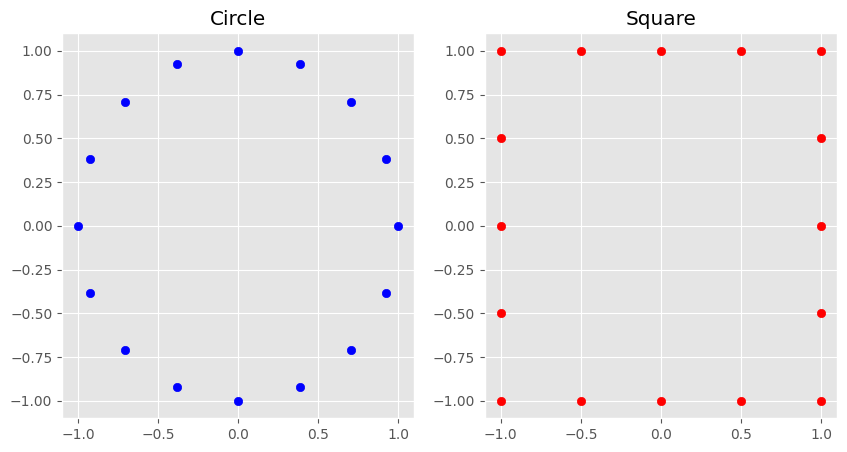

In [104]:
circles = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
ax[0].set_title("Circle")
ax[1].scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
ax[1].set_title("Square")
print(circles.shape, squares.shape)

(5, 51, 32)


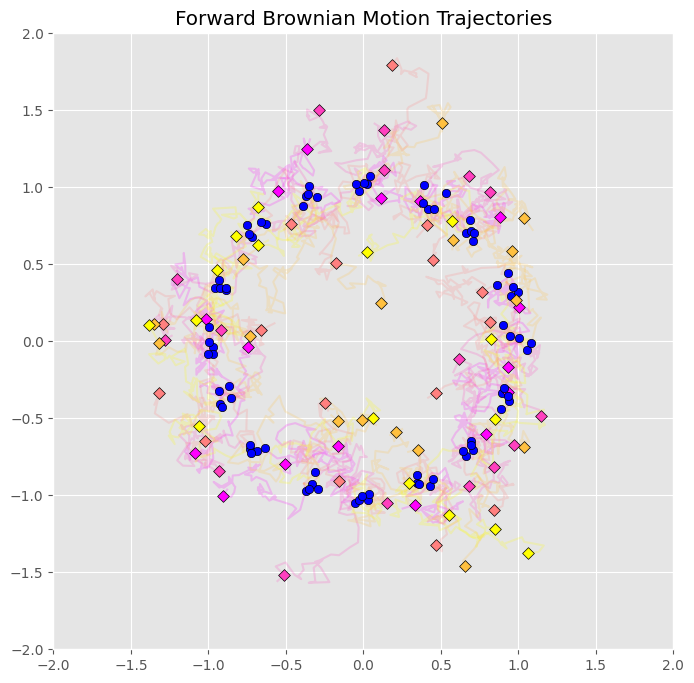

In [105]:
forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(circles, reps=(5, 1)))
print(forward_brownian_motion["trajectories"].shape)
plot_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [106]:
setup_params = {
    "network": {"out_dim": model.d,
                "time_embedding_dim": 128,
                "embedding_dim": 128,
                "act": 'leaky_relu',
                "encoder_layer_dims": [128, 128],
                "decoder_layer_dims": [128, 128],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 20,
                 "num_batches_per_epoch": 64,
                 "learning_rate": 2e-3}
}
score_p_state = model.learn_p_score(initial_condition=circles, 
                                    setup_params=setup_params)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

(1, 51, 32)


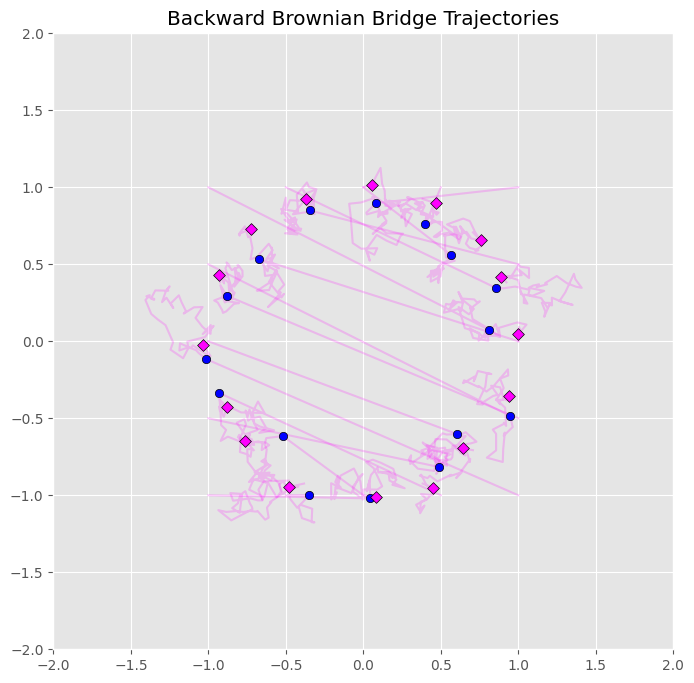

In [108]:
backward_brownian_bridge = model.simulate_backward_bridge(score_p_state=score_p_state, 
                                                          initial_condition=jnp.tile(squares, reps=(1, 1)), 
                                                          terminal_condition=jnp.tile(circles, reps=(1, 1)))
print(backward_brownian_bridge["trajectories"].shape)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")